In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import doc_retention_utils as dr

# Compare the fit of exponential models to the Catalan et al. (2016) dataset with and without k=f(t)

# Read in data

In [3]:
# Read in data
data_fpath = r"data/catalan_2016_doc_data.xlsx"
df_full = pd.read_excel(data_fpath, usecols="A:M")

df_full.rename(
    {
        "WRT (years) ": "tau",
        "Degradation rate temperature corrected (d-1)": "k_per_day",
        "FieldII": "Method",
        "System10": "System",
    },
    axis="columns",
    inplace=True,
)

# Sort by tau for plotting later
df_full = df_full.sort_values(by="tau", ascending=False)

# Repeat some of the preprocessing done in Excel on the raw data (less liable to errors)
df_full["k"] = df_full["k_per_day"] * 365
df_full["mo_mi"] = np.exp(-df_full["k"] * df_full["tau"])
df_full["tau_days"] = df_full["tau"] * 365

# Some ln transforms for regression later
df_full["ln_tau"] = np.log(df_full["tau"])
df_full["ln_k"] = np.log(df_full["k"])

# Also drop data that Catalan et al. excluded from their regression analyses, for comparability
df = df_full.loc[df_full["Excluded from analysis"] == 0].copy()

# For future playing, split into two groups (N.B. this is AFTER dropping the data they don't use)
df_natural = df.copy().loc[df_full["Method"] == "FieldModel"]
df_natural_full = df_full.copy().loc[df_full["Method"] == "FieldModel"]
df_bioassay = df.copy().loc[df_full["Method"] == "Bioassay"]

df_full.head()

,Id,Method,Cite,Reference number,System,Climate Köppen-Geiger classification (Kottek et al. 2006),Site,Latitude (d.d.),Longitude (d.d.),tau,k_per_day,Type,Excluded from analysis,k,mo_mi,tau_days,ln_tau,ln_k
330,Aditional_331,FieldModel,"Hansell and Carlson, 1998",46,Ocean,Ocean,Greenland to North Atlantic,63.937373,-34.127199,595.0,9.450100e-07,Field-Ocean,1,0.000345,0.814458,217175.0,6.388561,-7.972173
328,Aditional_329,FieldModel,Jeansson et al. 2011,45,Ocean,Ocean,Nordic seas,57.302790,2.981872,128.0,5.051350e-07,Field-Ocean,1,0.000184,0.976676,46720.0,4.852030,-8.598543
329,Aditional_330,FieldModel,"Hansell and Carlson, 1998",46,Ocean,Ocean,Greenland to North Atlantic,63.937373,-34.127199,80.0,3.292600e-06,Field-Ocean,1,0.001202,0.908333,29200.0,4.382027,-6.723936
273,274,FieldModel,"Stephens and Minor, 2010",36,Lake,Dfb,Superior,47.765176,-86.985054,42.0,1.120450e-04,Field-Lake,0,0.040896,0.179487,15330.0,3.737670,-3.196713
332,Aditional_333,FieldModel,Anderson et al.1998,48,Ocean,Ocean,Arctic,83.194896,105.769039,30.0,8.567920e-06,Field-Ocean,1,0.003127,0.910448,10950.0,3.401197,-5.767588


# Read in newly gathered instream DOC mass balance data

In [4]:
riv_df = pd.read_csv(r'data/review_instream_doc_retention_summary.csv')

# Rename to match Catalan et al. data
riv_df.rename({'Transmission (M_out/M_in)': 'mo_mi'}, axis=1, inplace=True)
riv_df['tau'] = riv_df['t (days)'] / 365  # Tau in years
riv_df.head()

,Site,mo_mi,t (days),Stream order,Ref,Exclude_expts,tau
0,"NE Spain, site and sample median",1.000000,0.250000,Reaches in 2nd-4th order streams,Casas-Ruiz et al. (2017),0,0.000685
1,"Wood Brook, England",0.982609,0.090981,1st order,Khamis et al. (2021),0,0.000249
2,"Site average, small Alaskan streams",0.918568,0.001946,Headwaters (order not given),Fellman et al. (2009),1,0.000005
3,"Creeping Swamp, North Carolina, USA",0.360000,9.259259,3rd,Mulholland (1981),0,0.025368
4,"Fort River, Massachusetts, USA",0.960000,0.132331,4th,Fisher (1977),0,0.000363


# Fit and compare models

Compare models using differences in BIC and a likelihood ratio test (LRT).

A difference in AIC or BIC of more than 10 is often considered strong evidence that the model with the lower value is significantly better (Raftery 1995). A Likelihood Ratio Test is used when the models are nested, meaning one model is a special case of the other. The LRT compares the goodness-of-fit of the two models by evaluating the difference in their log-likelihoods.

Raftery, A. E. (1995). Bayesian Model Selection in Social Research. Sociological Methodology, 25, 111-163

## Exponential to full dataset

In [5]:
print(len(df), "Data points in the TOC dataset.")

print("\n\nFit for 'option 1'")
toc_fit1 = dr.fit_model(dr.transmission_k_constant, df, "tau", "mo_mi")

print("\n\nFit for 'option 2'")
toc_fit2 = dr.fit_model(dr.transmission_k_as_func_of_tau, df, "tau", "mo_mi")

315 Data points in the TOC dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_k_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 315
    # variables        = 1
    chi-square         = 16.0363759
    reduced chi-square = 0.05107126
    Akaike info crit   = -935.979595
    Bayesian info crit = -932.227023
    R-squared          = 0.36356275
[[Variables]]
    k:  0.28222207 +/- 0.02220045 (7.87%) (init = 0.5)
R2: 0.42


Fit for 'option 2'
[[Model]]
    Model(transmission_k_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 315
    # variables        = 2
    chi-square         = 11.9129360
    reduced chi-square = 0.03806050
    Akaike info crit   = -1027.60855
    Bayesian info crit = -1020.10340
    R-squared          = 0.52721012
[[Variables]]
    p:  0.46653635 +/- 0.02386734 (5.12%) (init = 0.5)
    m: -0.56210566 +/- 0.03056762 (5.44%) (

In [6]:
dr.likelihood_ratio_test(toc_fit1, toc_fit2)

Likelihood Ratio: 4.123439958480745
Degrees of Freedom: 1
P-value: 0.042


In [7]:
# R2 and MAE  
pred1 = toc_fit1.eval(tau=df['tau'].values)
dr.rs_mae(df['mo_mi'], pred1, 'Fit 1')
dr.calculate_bic(df['mo_mi'], pred1, 1)

pred2 = toc_fit2.eval(tau=df['tau'].values)
dr.rs_mae(df['mo_mi'], pred2, 'Fit 2')
dr.calculate_bic(df['mo_mi'], pred2, 2)

T_catalan = np.exp(-0.38 * df['tau'].values ** 0.55)
dr.rs_mae(df['mo_mi'], T_catalan, 'Catalan')
dr.calculate_bic(df['mo_mi'], T_catalan, 2)

Fit 1:
R2: 0.36 MAE: 0.15
-932.2270227550454
Fit 2:
R2: 0.53 MAE: 0.14
-1020.1034030404828
Catalan:
R2: 0.5 MAE: 0.13
-1003.938342120322


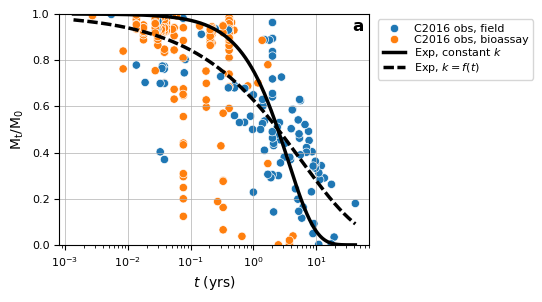

In [8]:
# Plot all models on one plot
fig, ax = plt.subplots(figsize=(4, 3))

# Plot observations
sns.scatterplot(data=df, x='tau', y='mo_mi', color='0.4', hue='Method')

# Plot each model's fit
tau_values = np.linspace(df['tau'].min()/2, df['tau'].max(), 100000)
color = 'k'
lw = 2.5
dashes = (3, 1)

ax.plot(tau_values, toc_fit1.eval(tau=tau_values), color=color, lw=lw, label=r'Exp, constant $k$')
ax.plot(tau_values, toc_fit2.eval(tau=tau_values), ls='--', color=color, lw=lw, dashes=dashes, label=r'Exp, $k = f(t)$')

plt.ylim(0, 1)
plt.xscale('log')

plt.grid(True, which='major', linewidth=0.5)

# Add labels and legend
plt.ylabel('$\mathrm{M_t/M_0}$', size=10)
plt.xlabel((r'$t$ (yrs)'), size=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize=8, bbox_to_anchor=(1.01, 1))

# Update legend labels for observations
label_rename_dict = {'FieldModel': 'C2016 obs, field',
                     'Bioassay': 'C2016 obs, bioassay'}

plt.legend(fontsize=8, bbox_to_anchor=(1.01, 1), labelspacing=0.1)
legend = plt.gca().get_legend()
for text in legend.get_texts():
    label = text.get_text()
    if label in label_rename_dict:
        text.set_text(label_rename_dict[label])
plt.draw()

# Add the plot location label in bold text to the top right corner
plt.text(0.98, 0.98, 'a', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')

plt.savefig(r'graphs/compare_models_catalan_data.png', bbox_inches='tight')

# Show plot
plt.show()

## Fit lines for bioassay and field data separately

In [9]:
# Bioassay
print(len(df_bioassay), "Data points TOC dataset.")

print("\n\nFit for 'option 1'")
bioassay_fit1 = dr.fit_model(dr.transmission_k_constant, df_bioassay, "tau", "mo_mi")

print("\n\nFit for 'option 2'")
bioassay_fit2 = dr.fit_model(dr.transmission_k_as_func_of_tau, df_bioassay, "tau", "mo_mi")

208 Data points TOC dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_k_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 208
    # variables        = 1
    chi-square         = 8.40966583
    reduced chi-square = 0.04062640
    Akaike info crit   = -665.296519
    Bayesian info crit = -661.958981
    R-squared          = 0.29987409
[[Variables]]
    k:  0.65449837 +/- 0.07674360 (11.73%) (init = 0.5)
R2: 0.35


Fit for 'option 2'
[[Model]]
    Model(transmission_k_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 208
    # variables        = 2
    chi-square         = 7.77839575
    reduced chi-square = 0.03775920
    Akaike info crit   = -679.527097
    Bayesian info crit = -672.852020
    R-squared          = 0.35242892
[[Variables]]
    p:  0.58464797 +/- 0.06041557 (10.33%) (init = 0.5)
    m: -0.38940976 +/- 0.06701429 (17.21%) (init 

In [10]:
dr.likelihood_ratio_test(bioassay_fit1, bioassay_fit2)

Likelihood Ratio: 0.6312700783314478
Degrees of Freedom: 1
P-value: 0.427


In [11]:
pred1 = bioassay_fit1.eval(tau=df_bioassay['tau'].values)
dr.rs_mae(df_bioassay['mo_mi'], pred1, 'Fit 1')
dr.calculate_bic(df_bioassay['mo_mi'], pred1, 1)

pred2 = bioassay_fit2.eval(tau=df_bioassay['tau'].values)
dr.rs_mae(df_bioassay['mo_mi'], pred2, 'Fit 2')
dr.calculate_bic(df_bioassay['mo_mi'], pred2, 2)

Fit 1:
R2: 0.3 MAE: 0.12
-661.9589808582903
Fit 2:
R2: 0.35 MAE: 0.12
-672.8520203602982


In [12]:
# Field
print(len(df_natural), "Field-based data points")

print("\n\nFit for 'option 1'")
field_exp_fit1 = dr.fit_model(dr.transmission_k_constant, df_natural, "tau", "mo_mi")

print("\n\nFit for 'option 2'")
field_exp_fit2 = dr.fit_model(dr.transmission_k_as_func_of_tau, df_natural, "tau", "mo_mi")

107 Field-based data points


Fit for 'option 1'
[[Model]]
    Model(transmission_k_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 107
    # variables        = 1
    chi-square         = 5.66727306
    reduced chi-square = 0.05346484
    Akaike info crit   = -312.378923
    Bayesian info crit = -309.706094
    R-squared          = 0.18513573
[[Variables]]
    k:  0.20752346 +/- 0.01877517 (9.05%) (init = 0.5)
R2: 0.23


Fit for 'option 2'
[[Model]]
    Model(transmission_k_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 107
    # variables        = 2
    chi-square         = 3.73131946
    reduced chi-square = 0.03553638
    Akaike info crit   = -355.099161
    Bayesian info crit = -349.753503
    R-squared          = 0.46349525
[[Variables]]
    p:  0.49213688 +/- 0.03907428 (7.94%) (init = 0.5)
    m: -0.64195265 +/- 0.04880341 (7.60%) (init = -

In [13]:
dr.likelihood_ratio_test(field_exp_fit1, field_exp_fit2)

Likelihood Ratio: 1.9359536092299945
Degrees of Freedom: 1
P-value: 0.164


In [14]:
pred1 = field_exp_fit1.eval(tau=df_natural['tau'].values)
dr.rs_mae(df_natural['mo_mi'], pred1, 'Fit 1')
dr.calculate_bic(df_natural['mo_mi'], pred1, 1)

pred2 = field_exp_fit2.eval(tau=df_natural['tau'].values)
dr.rs_mae(df_natural['mo_mi'], pred2, 'Fit 2')
dr.calculate_bic(df_natural['mo_mi'], pred2, 2)

Fit 1:
R2: 0.19 MAE: 0.2
-309.7060939255978
Fit 2:
R2: 0.46 MAE: 0.14
-349.75350299171646


## Fit Vollenweider models on the field data

In [15]:
print(len(df_natural), "Data points in TOC field data dataset.")

print("\n\nFit for Vollenweider, constant sigma")
field_voll_fit1 = dr.fit_model(dr.transmission_sigma_constant, df_natural, "tau", "mo_mi")

print("\n\nFit for Vollenweider, sigma=f(t)")
field_voll_fit2 = dr.fit_model(dr.transmission_sigma_as_func_of_tau, df_natural, "tau", "mo_mi")

107 Data points in TOC field data dataset.


Fit for Vollenweider, constant sigma
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 107
    # variables        = 1
    chi-square         = 4.72630606
    reduced chi-square = 0.04458779
    Akaike info crit   = -331.806284
    Bayesian info crit = -329.133455
    R-squared          = 0.32043191
[[Variables]]
    sigma:  0.35449105 +/- 0.03801728 (10.72%) (init = 0.5)
R2: 0.34


Fit for Vollenweider, sigma=f(t)
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 107
    # variables        = 2
    chi-square         = 3.86725383
    reduced chi-square = 0.03683099
    Akaike info crit   = -351.270408
    Bayesian info crit = -345.924750
    R-squared          = 0.44395004
[[Variables]]
    k:  0.66757261 +/- 0.06721700 (10.07%) (in

In [16]:
dr.likelihood_ratio_test(field_voll_fit1, field_voll_fit2)

Likelihood Ratio: 0.8590522288498201
Degrees of Freedom: 1
P-value: 0.354


## Plot all results on one plot

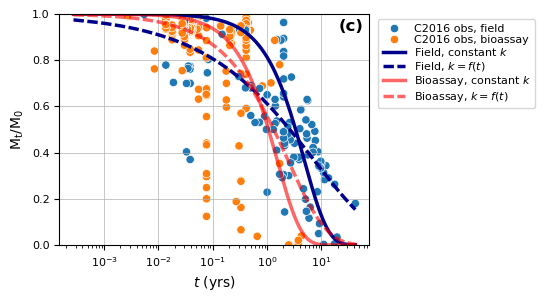

In [18]:
# Which data to plot?
plot_df = df

fig, ax = plt.subplots(figsize=(4, 3))

# Plot observations
sns.scatterplot(data=plot_df, x='tau', y='mo_mi', color='0.4', hue='Method', ax=ax)

# Plot each model's fit
tau_values = np.linspace(df['tau'].min()/10, df['tau'].max(), 100000)
lw = 2.5
dashes = (3, 1)

# Fit to field data
field_color = 'darkblue'
ax.plot(tau_values, field_exp_fit1.eval(tau=tau_values), color=field_color, lw=lw, label=r'Field, constant $k$')
ax.plot(tau_values, field_exp_fit2.eval(tau=tau_values), ls='--', color=field_color, lw=lw, dashes=dashes, label=r'Field, $k = f(t$)')

# Fit to bioassay data
bio_color = 'red'
ax.plot(tau_values, bioassay_fit1.eval(tau=tau_values), color=bio_color, alpha=0.6, lw=lw, label=r'Bioassay, constant $k$')
ax.plot(tau_values, bioassay_fit2.eval(tau=tau_values), ls='--', color=bio_color, alpha=0.6, lw=lw, dashes=dashes, label=r'Bioassay, $k = f(t$)')

# # Fit to whole dataset
# color='k'
# ax.plot(tau_values, toc_fit1.eval(tau=tau_values), color=color, lw=lw, label=r'all data, constant $k$')
# ax.plot(tau_values, toc_fit2.eval(tau=tau_values), ls='--', color=color, lw=lw, dashes=dashes, label=r'all data, $k = f(t$)')

plt.ylim(0, 1)
plt.xscale('log')

plt.grid(True, which='major', linewidth=0.5)

# Add labels and legend
plt.ylabel('$\mathrm{M_t/M_0}$', size=10)
plt.xlabel((r'$t$ (yrs)'), size=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize=8, bbox_to_anchor=(1.01, 1))

# Update legend labels for observations
label_rename_dict = {'FieldModel': 'C2016 obs, field',
                     'Bioassay': 'C2016 obs, bioassay'}

plt.legend(fontsize=8, bbox_to_anchor=(1.01, 1), labelspacing=0.1)
legend = plt.gca().get_legend()
for text in legend.get_texts():
    label = text.get_text()
    if label in label_rename_dict:
        text.set_text(label_rename_dict[label])
plt.draw()

# Add the plot location label in bold text to the top right corner
plt.text(0.98, 0.98, '(c)', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')

plt.savefig(r'graphs/compare_models_catalan_data_bioassay-vs-field.png', bbox_inches='tight')

# Show plot
plt.show()

# Look at residuals

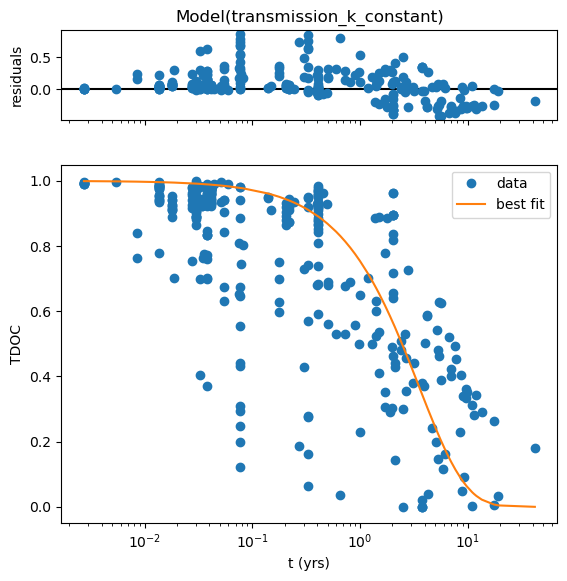

In [25]:
# Exponential, constant k
toc_fit1.plot(xlabel="t (yrs)", ylabel="TDOC");
plt.xscale('log')

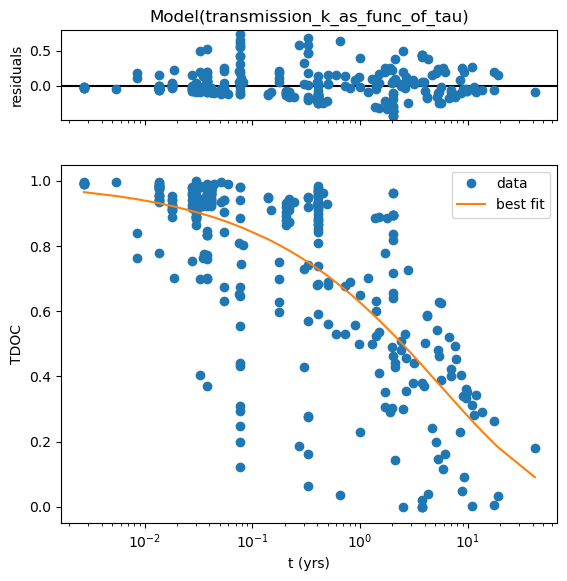

In [26]:
# Exponential, k = f(t)
toc_fit2.plot(xlabel="t (yrs)", ylabel="TDOC");
plt.xscale('log')

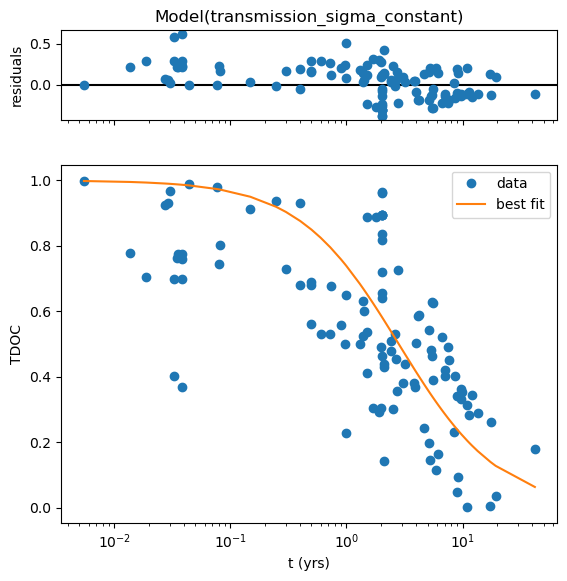

In [27]:
# Field data only, Vollenweider, constant sigma
field_voll_fit1.plot(xlabel="t (yrs)", ylabel="TDOC");
plt.xscale('log')

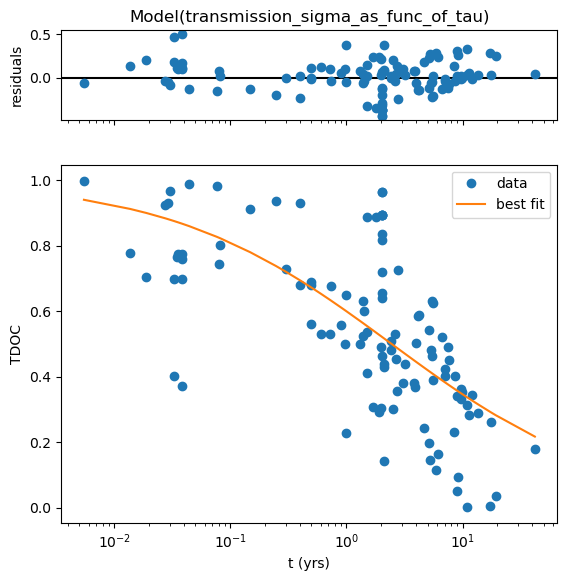

In [28]:
# Field data only, Vollenweider, sigma=f(t)
field_voll_fit2.plot(xlabel="t (yrs)", ylabel="TDOC");
plt.xscale('log')

# Plot just field data results

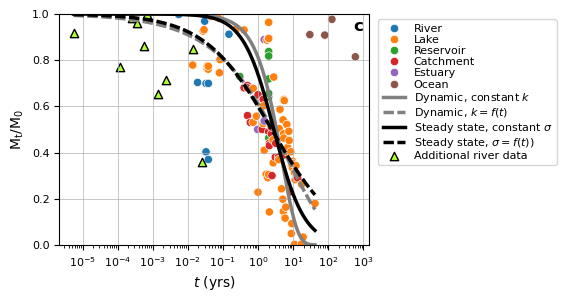

In [29]:
# Which data to plot?
plot_df = df_natural_full

fig, ax = plt.subplots(figsize=(4, 3))

# Plot observations
sns.scatterplot(data=plot_df, x='tau', y='mo_mi', color='0.4', hue='System', ax=ax)

# Plot each model's fit
tau_values = np.logspace(np.log10(riv_df['tau'].min()), np.log10(df['tau'].max()), 1000)
lw = 2.5
dashes = (3, 1)

# Fit to field data
field_color_exp = 'grey'
ax.plot(tau_values, field_exp_fit1.eval(tau=tau_values), color=field_color_exp, lw=lw, label=r'Dynamic, constant $k$')
ax.plot(tau_values, field_exp_fit2.eval(tau=tau_values), ls='--', color=field_color_exp, lw=lw, dashes=dashes, label=r'Dynamic, $k = f(t$)')

field_color_voll = 'black'
ax.plot(tau_values, field_voll_fit1.eval(tau=tau_values), color=field_color_voll, lw=lw, label=r'Steady state, constant $\sigma$')
ax.plot(tau_values, field_voll_fit2.eval(tau=tau_values), ls='--', color=field_color_voll, lw=lw, dashes=dashes, label=r'Steady state, $\sigma = f(t$))')

# Add newly gathered stream metabolism data
new_color = 'greenyellow'
ax.scatter(riv_df['tau'], riv_df['mo_mi'], marker='^', color=new_color, edgecolors='k', label='Additional river data')

plt.ylim(0, 1)
# plt.xlim(-0.5, 10)
plt.xscale('log')

plt.grid(True, which='major', linewidth=0.5)

# Add labels and legend
plt.ylabel('$\mathrm{M_t/M_0}$', size=10)
plt.xlabel((r'$t$ (yrs)'), size=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize=8, bbox_to_anchor=(1.01, 1), labelspacing=0.1)

# Add the plot location label in bold text to the top right corner
plt.text(0.98, 0.98, 'c', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')

plt.savefig(r'graphs/compare_models_catalan_data_field-only.png', bbox_inches='tight')

# Show plot
plt.show()

## Residuals for new river data

In [33]:
riv_df['predict_k_Catalan'] = np.exp(-0.45 * np.log(riv_df['tau']) - 0.96)
riv_df['predict_trans_Catalan'] = np.exp(-riv_df['predict_k_Catalan'] * riv_df['tau'])
riv_df['predict_exp_field1'] = field_exp_fit1.eval(tau=riv_df['tau'])
riv_df['predict_exp_field2'] = field_exp_fit2.eval(tau=riv_df['tau'])

riv_df['errors_Catalan'] = riv_df['mo_mi'] - riv_df['predict_trans_Catalan']
riv_df['errors_exp_field1'] = riv_df['mo_mi'] - riv_df['predict_exp_field1']
riv_df['errors_exp_field2'] = riv_df['mo_mi'] - riv_df['predict_exp_field2']

print(riv_df[['tau', 'mo_mi', 'errors_Catalan', 'errors_exp_field1', 'errors_exp_field2']].mean())

riv_df

tau                  0.004493
mo_mi                0.807200
errors_Catalan      -0.179350
errors_exp_field1   -0.191869
errors_exp_field2   -0.145444
dtype: float64


,Site,mo_mi,t (days),Stream order,Ref,tau,predict_k_Catalan,predict_trans_Catalan,predict_exp_field1,predict_exp_field2,errors_Catalan,errors_exp_field1,errors_exp_field2
0,"NE Spain, site and sample median",1.000,0.250,Reaches in 2nd-4th order streams,Casas-Ruiz et al. (2017),0.000685,10.163331,0.993063,0.999858,0.964413,0.006937,0.000142,0.035587
1,"Wood Brook, England",0.983,0.091,1st order,Khamis et al. (2021),0.000249,16.015498,0.996015,0.999948,0.975081,-0.013015,-0.016948,0.007919
2,"Site average, small Alaskan streams with natur...",0.919,0.002,Headwaters (order not given),Fellman et al. (2009),0.000005,89.257679,0.999511,0.999999,0.993588,-0.080511,-0.080999,-0.074588
3,"Creeping Swamp, North Carolina, USA",0.360,9.259,3rd,Mulholland (1981),0.025367,2.000577,0.950517,0.994749,0.876290,-0.590517,-0.634749,-0.516290
4,"Fort River, Massachusetts, USA",0.960,0.132,4th,Fisher (1977),0.000362,13.547240,0.995113,0.999925,0.971582,-0.035113,-0.039925,-0.011582
5,"SE China, TLC, average",0.713,0.886,1st-2nd order,Gong et al. (2021),0.002427,5.751272,0.986136,0.999496,0.944594,-0.273136,-0.286496,-0.231594
6,"SE China, YRC, average",0.654,0.526,1st-2nd order,Gong et al. (2021),0.001441,7.272195,0.989575,0.999701,0.953807,-0.335575,-0.345701,-0.299807
7,"Glensaugh, Scotland",0.770,0.042,1st order,Demars (2019),0.000115,22.680201,0.997394,0.999976,0.981049,-0.227394,-0.229976,-0.211049
8,"Medium river, MA (USA)",0.850,5.000,400 km2 upstream area,Wollheim et al. (2015),0.013699,2.639809,0.964484,0.997161,0.899502,-0.114484,-0.147161,-0.049502
9,"Peaty headwater, NE Scotland",0.863,0.210,1st,Dawson et al. (2001),0.000575,10.992853,0.993695,0.999881,0.966530,-0.130695,-0.136881,-0.103530


# Compare bioassay and river data

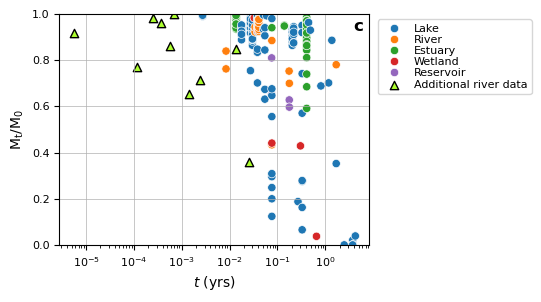

In [34]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot observations
sns.scatterplot(data=df_bioassay, x='tau', y='mo_mi', color='0.4', hue='System', ax=ax)
ax.scatter(riv_df['tau'], riv_df['mo_mi'], marker='^', color=new_color, edgecolors='k', label='Additional river data')

plt.ylim(0, 1)
# plt.xlim(-0.5, 10)
plt.xscale('log')

plt.grid(True, which='major', linewidth=0.5)

# Add labels and legend
plt.ylabel('$\mathrm{M_t/M_0}$', size=10)
plt.xlabel((r'$t$ (yrs)'), size=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize=8, bbox_to_anchor=(1.01, 1), labelspacing=0.1)

# Add the plot location label in bold text to the top right corner
plt.text(0.98, 0.98, 'c', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')

# plt.savefig(r'graphs/compare_models_catalan_data_field-only.png', bbox_inches='tight')

# Show plot
plt.show()

There is very little overlap in the t of the bioassay vs the river data. Instead, need to look at field data as a whole.

# Interpretation
Without the bioassay data, the field data (which is pretty dominated by lakes) doesn't show any big difference between f=k(t) vs constant k. Certainly no significant difference. Different models are more or less capable of producing the same thing. So it's not a question of Vollenweider vs exponential decay. It looks like more of a question of bioassay vs field data.